<center><img src="https://i.imgur.com/zRrFdsf.png" width="700"></center>










# Spatial and Multivariare analysis

## Getting Ready


Here, I will use data from Peru again:

In [3]:
import geopandas as gpd

peruDataLink="https://github.com/CienciaDeDatosEspacial/dataSets/raw/refs/heads/main/PERU/PeruMaps.gpkg"
datadisMap=gpd.read_file(peruDataLink,layer='good_geom')

## Mining several variables

Let me select some columns:

In [4]:
selected_variables = ['Educ_sec_comp2019_pct',
                     'NBI2017_pct', 
                     'Viv_sin_serv_hig2017_pct']


<Axes: >

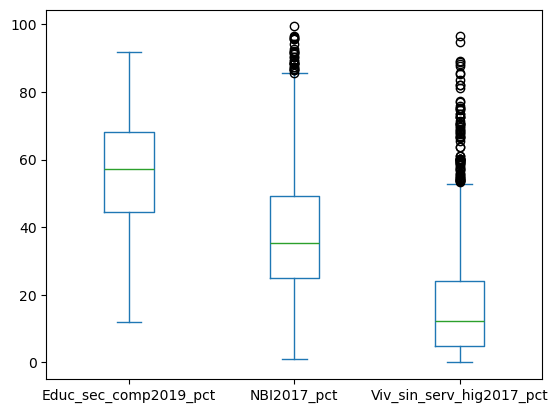

In [7]:
# see distribution
datadisMap[selected_variables].plot(kind='box')

Let me check their monotony:

In [8]:
datadisMap[selected_variables].corr()

,Educ_sec_comp2019_pct,NBI2017_pct,Viv_sin_serv_hig2017_pct
Educ_sec_comp2019_pct,1.000000,-0.429787,-0.200867
NBI2017_pct,-0.429787,1.000000,0.662548
Viv_sin_serv_hig2017_pct,-0.200867,0.662548,1.000000


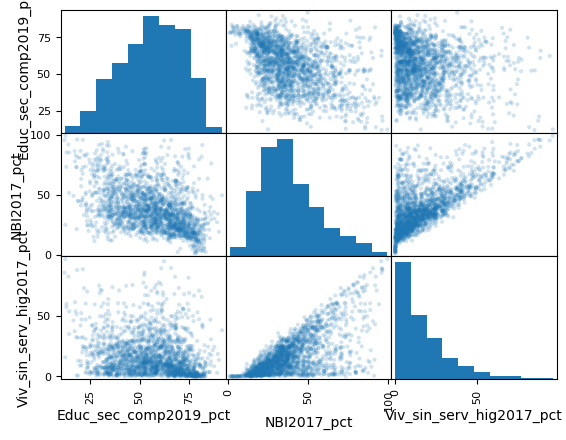

In [11]:
import pandas as pd
pd.plotting.scatter_matrix(datadisMap[selected_variables], alpha=0.2);

Here, we can reverse the values of *Educ_sec_comp2019_pct*. First let me standardize:

array([[<Axes: xlabel='0', ylabel='0'>, <Axes: xlabel='1', ylabel='0'>,
        <Axes: xlabel='2', ylabel='0'>],
       [<Axes: xlabel='0', ylabel='1'>, <Axes: xlabel='1', ylabel='1'>,
        <Axes: xlabel='2', ylabel='1'>],
       [<Axes: xlabel='0', ylabel='2'>, <Axes: xlabel='1', ylabel='2'>,
        <Axes: xlabel='2', ylabel='2'>]], dtype=object)

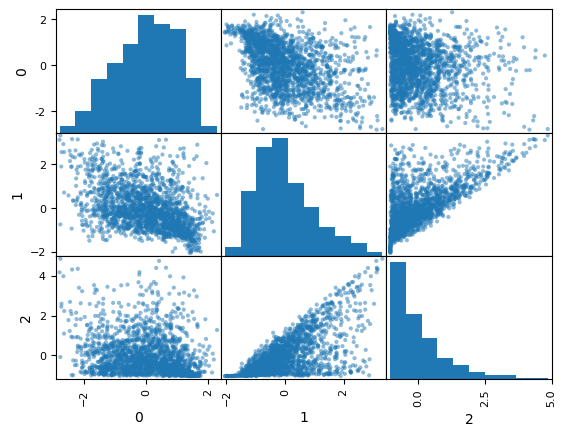

In [18]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
normalized_data = scaler.fit_transform(datadisMap[selected_variables])
pd.plotting.scatter_matrix(pd.DataFrame(normalized_data))

Let me create new variables with the standardized values:

In [19]:
# new names
selected_variables_new_std=[s+'_std' for s in selected_variables]

# add colunms
datadisMap[selected_variables_new_std]=normalized_data

Now, it is easy to reverse:

In [20]:
datadisMap['Educ_sec_NO_comp2019_pct_std']=-1*datadisMap.Educ_sec_comp2019_pct_std

array([[<Axes: xlabel='Educ_sec_NO_comp2019_pct_std', ylabel='Educ_sec_NO_comp2019_pct_std'>,
        <Axes: xlabel='NBI2017_pct_std', ylabel='Educ_sec_NO_comp2019_pct_std'>,
        <Axes: xlabel='Viv_sin_serv_hig2017_pct_std', ylabel='Educ_sec_NO_comp2019_pct_std'>],
       [<Axes: xlabel='Educ_sec_NO_comp2019_pct_std', ylabel='NBI2017_pct_std'>,
        <Axes: xlabel='NBI2017_pct_std', ylabel='NBI2017_pct_std'>,
        <Axes: xlabel='Viv_sin_serv_hig2017_pct_std', ylabel='NBI2017_pct_std'>],
       [<Axes: xlabel='Educ_sec_NO_comp2019_pct_std', ylabel='Viv_sin_serv_hig2017_pct_std'>,
        <Axes: xlabel='NBI2017_pct_std', ylabel='Viv_sin_serv_hig2017_pct_std'>,
        <Axes: xlabel='Viv_sin_serv_hig2017_pct_std', ylabel='Viv_sin_serv_hig2017_pct_std'>]],
      dtype=object)

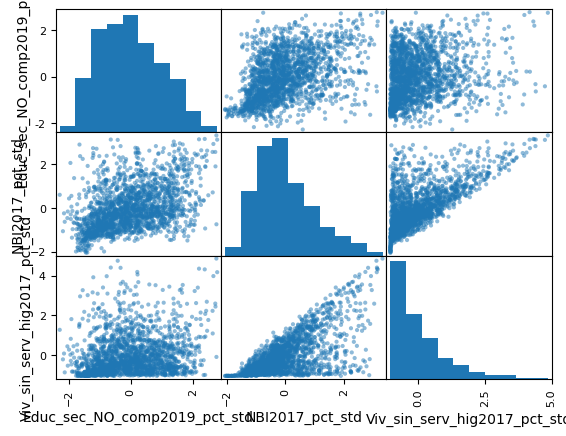

In [21]:
# as a result:
selected_variables_new_std = ['Educ_sec_NO_comp2019_pct_std',
                     'NBI2017_pct_std', 
                     'Viv_sin_serv_hig2017_pct_std']

pd.plotting.scatter_matrix(datadisMap[selected_variables_new_std])

### Conventional Clustering

Here, I will use the three variables to create clusters of districts. Let me explore how many clusters could be created:

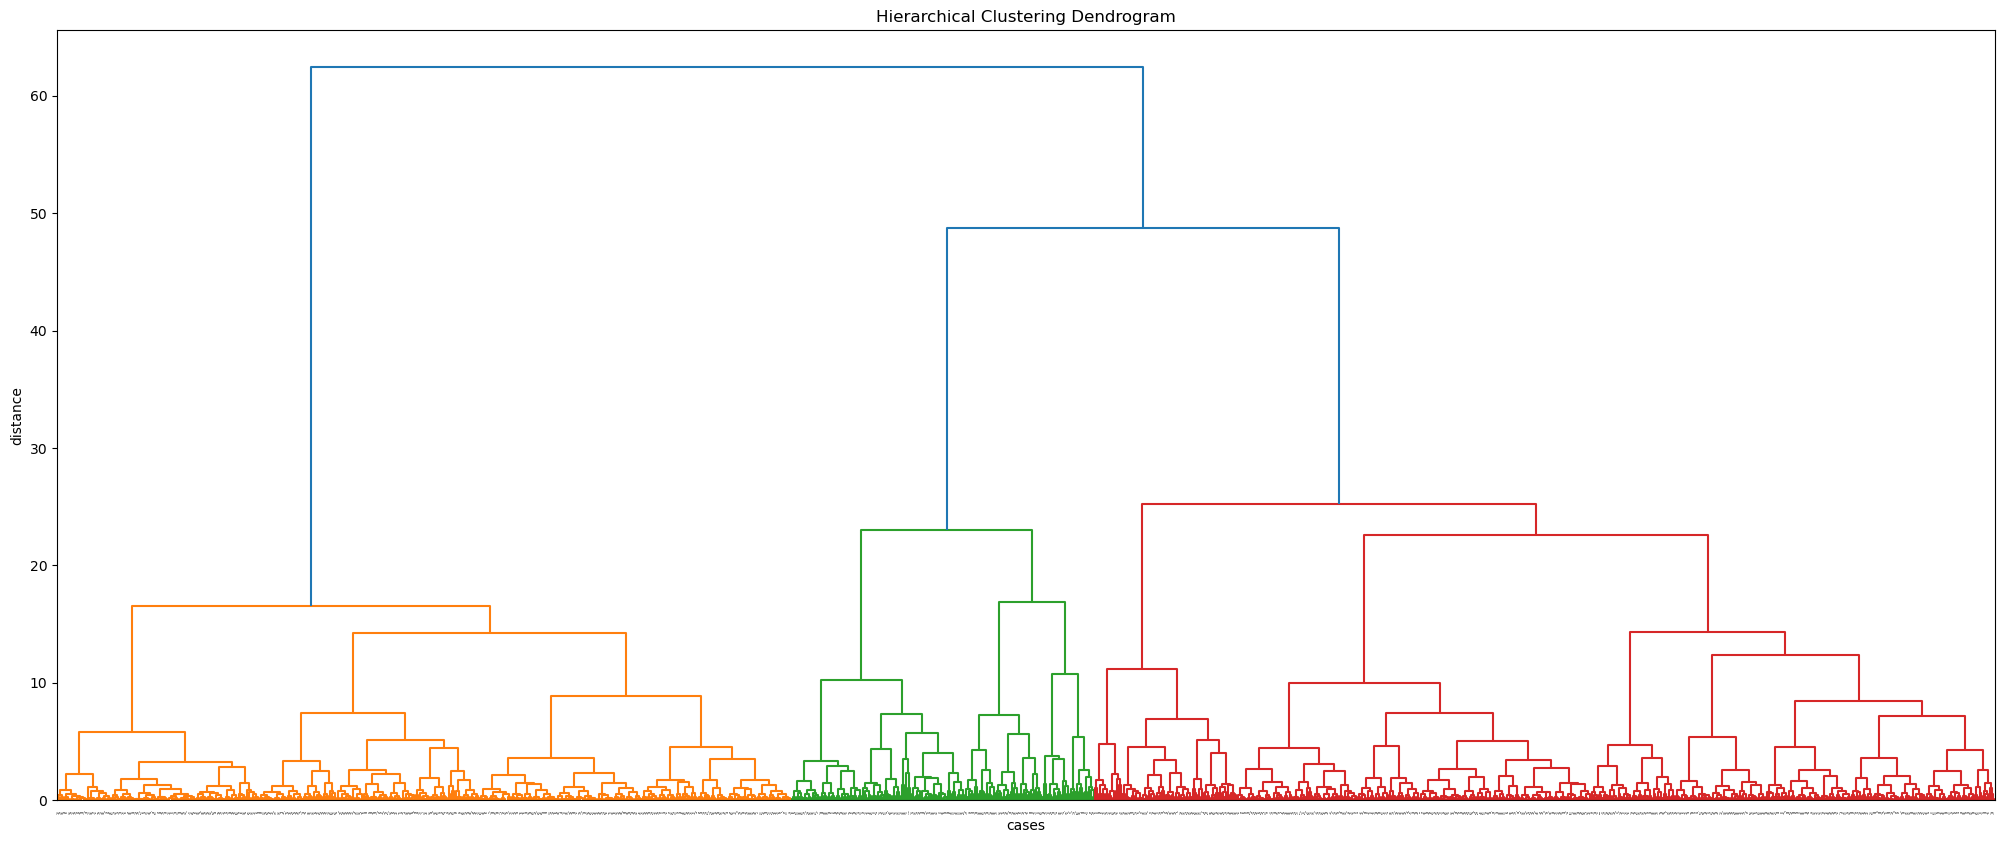

In [23]:
import  matplotlib.pyplot as plt
from scipy.cluster import hierarchy as hc


Z = hc.linkage(datadisMap[selected_variables_new_std], 'ward')
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('cases')
plt.ylabel('distance')
hc.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=1,  # font size for the x axis labels
)
plt.show()

The dendogram recommends three groups. Let me request five.

Let me use a common hierarchical technique following a agglomerative approach:

In [24]:
from sklearn.cluster import AgglomerativeClustering as agnes

import numpy as np
np.random.seed(12345)# Set seed for reproducibility

# Initialize the algorithm, requesting 5 clusters
model = agnes(linkage="ward", n_clusters=5).fit(datadisMap[selected_variables_new_std])

# Assign labels to main data table
datadisMap["hc_ag5"] = model.labels_

In [25]:
# see distribution of districts
datadisMap["hc_ag5"].value_counts()

hc_ag5
0    732
1    710
4    168
3    138
2    125
Name: count, dtype: int64

We could try to find the pattern that created the clusters:

In [27]:
datadisMap.groupby("hc_ag5")[selected_variables_new_std].mean()

,Educ_sec_NO_comp2019_pct_std,NBI2017_pct_std,Viv_sin_serv_hig2017_pct_std
hc_ag5,,,
0,0.550709,-0.053470,-0.078733
1,-0.839378,-0.802709,-0.597672
2,1.080205,1.920950,2.333349
3,0.839310,1.536194,-0.445523
4,-0.345304,0.934225,1.498770


Let me show you the six groups of districts which have similar behavior in three variables:

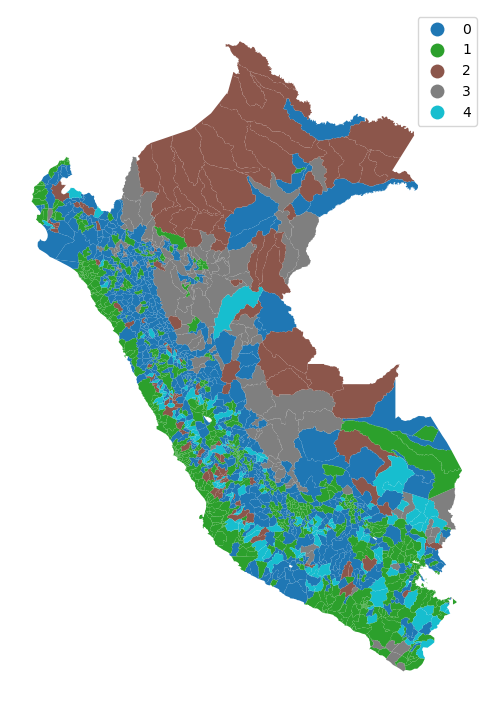

In [28]:
# Set up figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including
# a legend and with no boundary lines
datadisMap.plot(
    column="hc_ag5", categorical=True, legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

### Regionalization: Spatial Clustering 

Spatial clustering or Regionalization will force the contiguity of the polygons to make a cluster.

In [ ]:
# modify previous funtion call to specify cluster model with spatial constraint

model_queen = agnes(linkage="ward", 
                    n_clusters=5,
                    connectivity=w_queen.sparse).fit(datadisMap[selected_variables_new_std])
# Fit algorithm to the data
datadisMap["hc_ag5_wQueen"] = model_queen.labels_

We knew this would happen because we have islands. Then this results may not be satisfactory:

In [ ]:
# Set up figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
datadisMap.plot(
    column="hc_ag6_wQueen",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

We have a couple the KNN alternative. Let's use that instead:

In [ ]:
model_wknn8 = agnes(linkage="ward",
                    n_clusters=6,
                    connectivity=w_knn8.sparse).fit(datadisMap[selected_variables_new_std])
datadisMap["hc_ag6_wknn8"] = model_wknn8.labels_




In [ ]:
# Set up figure and ax
f, ax = plt.subplots(1, figsize=(10, 12))
# Plot unique values choropleth including a legend and with no boundary lines
datadisMap.plot(
    column="hc_ag6_wknn8",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

We could evaluate two aspects of these clustering results:

* “Compactness” of cluster shape, using the isoperimetric quotient (IPQ). This compares the area of the region to the area of a circle with the same perimeter as the region. For this measure, more compact shapes have an IPQ closer to 1, whereas very elongated or spindly shapes will have IPQs closer to zero. For the clustering solutions, we would expect the IPQ to be very small indeed, since the perimeter of a cluster/region gets smaller the more boundaries that members share.

In [ ]:
from esda import shape as shapestats
results={}
for cluster_type in ("hc_ag6_wknn8", "hc_ag6"):
    # compute the region polygons using a dissolve
    regions = datadisMap[[cluster_type, "geometry"]].to_crs(24892).dissolve(by=cluster_type)
    # compute the actual isoperimetric quotient for these regions
    ipqs = shapestats.isoperimetric_quotient(regions)
    # cast to a dataframe
    result = {cluster_type:ipqs}
    results.update(result)
# stack the series together along columns
pd.DataFrame(results)

An alternative could be _convex_hull_ratio_, simply the division of the area of the cluster by the area of its convex hull.

In [ ]:
from esda import shape as shapestats
results={}
for cluster_type in ("hc_ag6_wknn8", "hc_ag6"):
    # compute the region polygons using a dissolve
    regions = datadisMap[[cluster_type, "geometry"]].to_crs(24892).dissolve(by=cluster_type)
    # compute the actual convex hull quotient for these regions
    chullr = shapestats.convex_hull_ratio(regions)
    # cast to a dataframe
    result = {cluster_type:chullr}
    results.update(result)
# stack the series together along columns
pd.DataFrame(results)

In both cases, the spatial clusters do better.

* Goodness of fit. Here we have two metrics:
    - metrics.calinski_harabasz_score
    - silhouette_score

In [ ]:
from sklearn import metrics

fit_scores = []
for cluster_type in ("hc_ag6_wknn8", "hc_ag6"):
    # compute the CH score
    ch_score = metrics.calinski_harabasz_score(
        # using scaled variables
        datadisMap[selected_variables_new_std],
        # using these labels
        datadisMap[cluster_type],
    )
    sil_score = metrics.silhouette_score(
        # using scaled variables
        datadisMap[selected_variables_new_std],
        # using these labels
        datadisMap[cluster_type],
    )
    # and append the cluster type with the CH score
    fit_scores.append((cluster_type, ch_score,sil_score))


# re-arrange the scores into a dataframe for display
pd.DataFrame(
    fit_scores, columns=["cluster type", "CH score", "SIL score"]
).set_index("cluster type")

Here, the conventional clustering beats the others, as you want bigger values in both.

### Exercise 9

<div class="alert-success">
    
Use your three variables to carry out the cluster/regional analysis.
    
</div>


### Conventional Regression

This is a basic regression:

In [ ]:
from pysal.model import spreg

dep_var_name=['NBI2017_pct']
ind_vars_names=['Educ_sec_comp2019_pct','Viv_sin_serv_hig2017_pct']
labels=['Lack Basic Needs %','High-School completed %', 'No H-Hold sanitation %']

ols_model = spreg.OLS(
    # Dependent variable
    datadisMap[dep_var_name].values,
    # Independent variables
    datadisMap[ind_vars_names].values,
    # Dependent variable name
    name_y=labels[0],
    # Independent variable name
    name_x=labels[1:],
    name_ds='datadisMap')

print(ols_model.summary)

Would we have some spatial effect playing we have not noticed?

In [ ]:
# the dependent variable
moranNBI = Moran(datadisMap[dep_var_name], w_knn8)
moranNBI.I,moranNBI.p_sim

In [ ]:
# the error term
moranError = Moran(ols_model.u, w_knn8)
moranError.I,moranError.p_sim

We have a strong suggestion that either or both are playing here.

### Spatial Regression

I.  Spatial Lag Regression  (the dependent variable)

In [ ]:
SAC_model = spreg.ML_Lag(
    # Dependent variable
    datadisMap[dep_var_name].values,
    # Independent variables
    datadisMap[ind_vars_names].values,
    w=w_knn8,
    # Dependent variable name
    name_y=labels[0],
    # Independent variable name
    name_x=labels[1:],
    name_w='KNN8',
    name_ds='datadisMap'
    )

print(SAC_model.summary)

As you get this: Coefficient W_NBI2017_pct (ρ = 0.571, p = 0.000), you know that a 10% increase in deprivation in neighboring areas leads to a 5.71% increase in local deprivation. Then, Poverty is highly "contagious" across nearby regions. A policy suggestion: Anti-poverty programs must target entire clusters (not just individual areas) to break spillover cycles.

* Spatial Error Regression

In [ ]:
SER_model = spreg.ML_Error(
    # Dependent variable
    datadisMap[dep_var_name].values,
    # Independent variables
    datadisMap[ind_vars_names].values,
    w=w_knn8,
    # Dependent variable name
    name_y=labels[0],
    # Independent variable name
    name_x=labels[1:],
    name_w='KNN8',
    name_ds='datadisMap'
    )

print(SER_model.summary)

Strong Spatial Spillovers (λ = 0.837), meaning that 83.7% of unobserved deprivation factors (e.g., informal economies, cultural norms) spill over from neighboring areas. Then, poverty is highly contagious across space—a 10% deprivation increase in nearby regions raises local deprivation by 8.37% through hidden channels.

What if?

In [ ]:
SAC_model = spreg.GM_Combo_Het(
    # Dependent variable
    datadisMap[dep_var_name].values,
    # Independent variables
    datadisMap[ind_vars_names].values,
    w=w_knn8,
    # Dependent variable name
    name_y=labels[0],
    # Independent variable name
    name_x=labels[1:],
    name_w='KNN8',
    name_ds='datadisMap'
)

# Print results
print(SAC_model.summary)

The SAR is not needed, neither the SAC; SER is what matters; in this case.

### Exercise 10

<div class="alert-success">
    
Use your three variables to carry out regression analysis (conventional and spatial).
    
</div>